# Building a hate-speech classifier

## 1.0 Introduction

### 1.1 Goal:
- *Given a message written in English, we are challenged to classify whether the message is explicit or hateful in nature or whether it is clean.*

### 1.2 Purpose of this project:
- *To serve as a classifier for a Discord bot which should be able to identify if messages sent in the channel are profane or clean.*

### 1.3 Imports

In [4]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import lxml
import html5lib
from pdb import set_trace
from tqdm.notebook import tqdm
import umap
from sklearn.model_selection import train_test_split
import seaborn as sns
import wordninja
import pickle
from matplotlib import pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score
from prettytable import PrettyTable
import torch
from torch import optim
from torch import nn
from sklearn.utils import shuffle
from typing import List, Tuple


# optimization

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# models

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from pytorch_pretrained_bert import BertTokenizer, BertModel
from simpletransformers.classification import ClassificationModel, ClassificationArgs

C:\Users\yogid\anaconda3\envs\main\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\yogid\anaconda3\envs\main\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\yogid\anaconda3\envs\main\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


## 1.4 Loading the dataset

- The dataset has been taken from the 'Twitter Hate Speech' repository on Kaggle. [Click here](https://www.kaggle.com/vkrahul/twitter-hate-speech?select=train_E6oV3lV.csv) to download.
- The dataset contains multiple tweets and labels indicating whether that tweet was toxic or not

In [6]:
data = pd.read_csv('toxic_train.csv', index_col=0)
data.head()

,comment_text,toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [10]:
data.iloc[4].comment_text

"You, sir, are my hero. Any chance you remember what page that's on?"

In [7]:
data.shape

(159571, 2)

## 2.0 Data cleaning and Feature Engineering

## Train, test, validation split

* Let's split our data into train-test-validation sets before we do any analysis so as to not induce any bias towards the data

In [72]:
# let's split our data into 60-20-20

train, test = train_test_split(data, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.25, random_state=42)

#### Checking for duplicates

In [73]:
diff = len(train.comment_text) - len(train.comment_text.unique())
if diff:
    print('We have {} duplicate rows'.format(diff))
else:
    print('There are no duplicate rows.')

There are no duplicate rows.


#### Checking for null values

In [74]:
diff = len(train.comment_text) - len(train.comment_text.isnull())
if diff:
    print('We have {} null values'.format(diff))
else:
    print('There are no null values.')

There are no null values.


#### Checking for rows with less 2 words

In [75]:
# deleting rows with 1 word or less as it is mostly just noise

null_df = train[train.comment_text.str.split().apply(len) <= 1]
if len(null_df):
    print('There are {} rows with sentences that contain 1 word or lesser. Removing them...'.format(len(null_df)))
    train = train[~train.index.isin(null_df.index)]
    print('Deletion complete. Resultant shape of dataframe: {}'.format(data.shape))
else:
    print('All rows contain sentences with 2 words or more.')

There are 11 rows with sentences that contain 1 word or lesser. Removing them...
Deletion complete. Resultant shape of dataframe: (159571, 2)


#### Checking for invalid texts

In [76]:
# delete all rows which has sentences that contain less than tolerance percentage of alphabets

def count_alpha(text, tolerance=0.6):
    '''
    Returns True if the number of alphabets in the text is atlteast tolerance percentage
    of the length of the text else returns False
    '''
    if sum([c.isalpha() for c in text]) / len(text) >= tolerance:
        return True
    return False
    
    
def remove_invalid_text(text):
    '''
    Checks if text is valid by asserting that each sentence contains atleast tolerance percentage of alphabets in it.
    If valid, returns text as-is, else returns NaN
    '''
    if not count_alpha(text, tolerance=0.5):
        # string contains neither an alphabet nor is a mixture of alphabets and special characters
        return np.nan
    return text


train.comment_text = train.comment_text.apply(remove_invalid_text)
len_del = train[train.comment_text.isnull()].shape[0]
if len_del:
    print('Deleting {} rows from data...'.format(len_del))
    train = train[~train.comment_text.isnull()]
    print('Resultant shape of data: {}'.format(train.shape[0]))
else:
    print('There are no invalid text in the data.')

Deleting 1071 rows from data...
Resultant shape of data: 94660


#### Preprocessing text

In [77]:
stop_words = set(stopwords.words('english')) 

def preprocess_text(text):
    
    def remove_special_chars_and_numbers(text):
        '''
        Returns text without any special characters and numbers
        '''
        return text.translate(str.maketrans('', '', string.punctuation)).translate(str.maketrans('', '', string.digits))
    
    def remove_stopwords(text):
        '''
        Removes stopwords from text
        '''
        new_text = list()
        for word in text.split():
            if word not in stop_words:
                new_text.append(word)
        return ' '.join(new_text)
    
    def remove_html_tags(text):
        '''
        Removes html tags from the text
        '''
        return BeautifulSoup(str(text), 'html.parser').get_text()
    
    def remove_non_english_words(text):
        '''
        Removes all non-english words in the text
        '''
        pattern = r'[^\x00-\x7f]'
        new_text = ''
        for element_index, element in enumerate(text):
            if not re.search(pattern, element):
                new_text = new_text + element
        return new_text
    
    def do_lemmatization(text):
        lemma = WordNetLemmatizer()
        return lemma.lemmatize(text)
    
    def convert_lower_case(text):
        return text.lower()
    
    def remove_single_alphabets(text):
        new_text = list()
        for word in text.split():
            if len(word) == 1:
                if word.isalpha():
                    continue
            new_text.append(word)
        return ' '.join(new_text)
    
    text = remove_html_tags(text)
    text = remove_special_chars_and_numbers(text)
    text = remove_stopwords(text)
    text = remove_non_english_words(text)
    text = convert_lower_case(text)
    text = do_lemmatization(text)
    text = remove_single_alphabets(text)
    return text

tqdm.pandas()
train.comment_text = train.comment_text.progress_apply(preprocess_text)
train = train[train.comment_text.astype(bool)]

val.comment_text = val.comment_text.progress_apply(preprocess_text)
val = val[val.comment_text.astype(bool)]

test.comment_text = test.comment_text.progress_apply(preprocess_text)
test = test[test.comment_text.astype(bool)]

C:\Users\yogid\anaconda3\envs\main\lib\site-packages\bs4\__init__.py:424: MarkupResemblesLocatorWarning: "http://www.haaretz.com/news/diplomacy-defense/2-279-calories-per-person-how-israel-made-sure-gaza-didn-t-starve.premium-1.470419" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


C:\Users\yogid\anaconda3\envs\main\lib\site-packages\bs4\__init__.py:424: MarkupResemblesLocatorWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


C:\Users\yogid\anaconda3\envs\main\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Data analysis

#### Basic statistics

In [78]:
print('Total train-points: {}\nNumber of toxic comments: {:.2f}%\nNumber of non-toxic comments: {:.2f}%'.format(
    train.shape[0],
    train.toxic.value_counts(normalize=True)[1] * 100,
    train.toxic.value_counts(normalize=True)[0] * 100
        )
     )

Total train-points: 94658
Number of toxic comments: 9.51%
Number of non-toxic comments: 90.49%


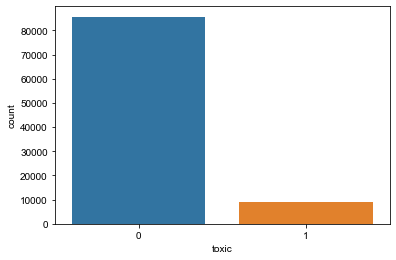

In [79]:
# let's visualize the imbalance

sns.countplot(x="toxic", data=train)
sns.set_style('whitegrid')

* We seem to have a pretty big class-imbalance issue, which we will fix later

#### Average length of a comment

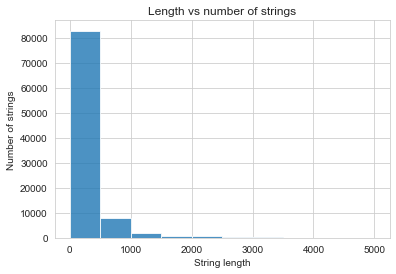

In [14]:
# plotting the distribution of lengths of texts

lengths = train.comment_text.apply(len)
lengths.plot(kind='hist', alpha=0.8)
plt.xlabel('String length')
plt.ylabel('Number of strings')
plt.title('Length vs number of strings')
plt.show()

* We see a very skewed Pareto distribution

#### Average length of a comment vs toxicity

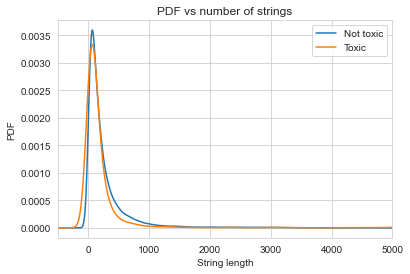

In [15]:
# plotting the distribution of lengths of texts

lengths_pos = train[train.toxic == 1].comment_text.apply(len)
lengths_neg = train[train.toxic == 0].comment_text.apply(len)

lengths_neg.plot(kind='kde', label='Not toxic')
lengths_pos.plot(kind='kde', label='Toxic')
plt.xlim([-500, 5000])

plt.legend()

plt.xlabel('String length')
plt.ylabel('PDF')
plt.title('PDF vs number of strings')
plt.show()

* We observe that both the distributions look almost identical. This indicates that the length of a comment is not a good indicator of its toxic nature.

#### Average word length within a comment

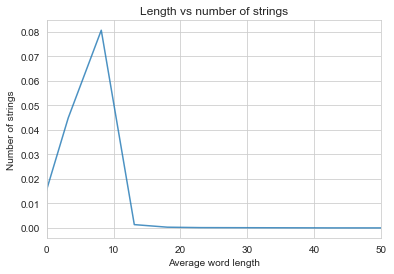

In [80]:
def get_word_length(text):
    return sum([len(word) for word in text.split()]) / len(text.split())


word_lengths = train.comment_text.apply(get_word_length)
word_lengths.plot(kind='kde', alpha=0.8)
plt.xlabel('Average word length')
plt.ylabel('Number of strings')
plt.title('Length vs number of strings')
plt.xlim([0, 50])
plt.show()

#### Average word-length vs toxicity

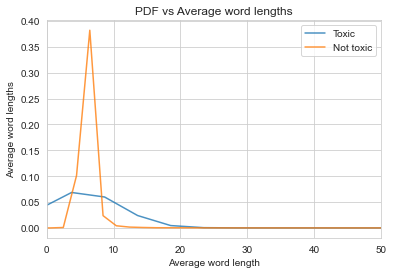

In [81]:
word_lengths_pos = pd.concat([train[train.toxic == 1]] * 10).comment_text.apply(get_word_length)
word_lengths_pos.plot(kind='kde', alpha=0.8, label='Toxic')

word_lengths_neg = train[train.toxic==0].comment_text.apply(get_word_length)
word_lengths_neg.plot(kind='kde', alpha=0.8, label='Not toxic')

plt.xlabel('Average word length')
plt.ylabel('Average word lengths')
plt.title('PDF vs Average word lengths')
plt.legend()
plt.xlim([0, 50])
plt.show()

* We observe that for comments having average word-lengths lesser than 15, the probability of that comment being not-toxic is significantly higher than the probability of it being toxic.

#### Most common words

In [82]:
def get_words(df):
    '''
    Returns list of words across all comments
    '''
    all_words, neg_words, pos_words = [], [], []
    for index in tqdm(range(df.shape[0])):
        row = df.iloc[index]
        words = row.comment_text.split()
        all_words.extend(words)
        if row.toxic:
            pos_words.extend(words)
        else:
            neg_words.extend(words)
    return all_words, pos_words, neg_words

all_words, pos_words, neg_words = get_words(train)

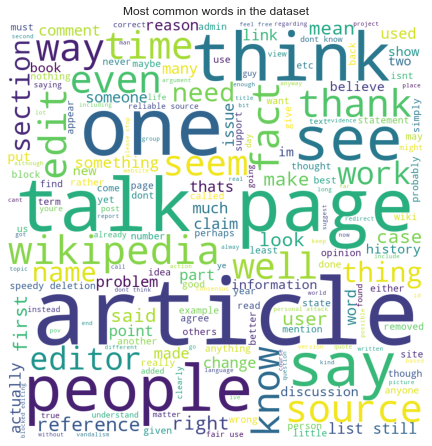

In [19]:
# displaying wordcloud of comments across all comments

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(' '.join(all_words))

# plot the WordCloud image                       
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Most common words in the dataset')
plt.tight_layout(pad = 0)
  
plt.show()

* Since the data is highly imbalanced, it should be noted that the majority of words would be from the non-toxic class.

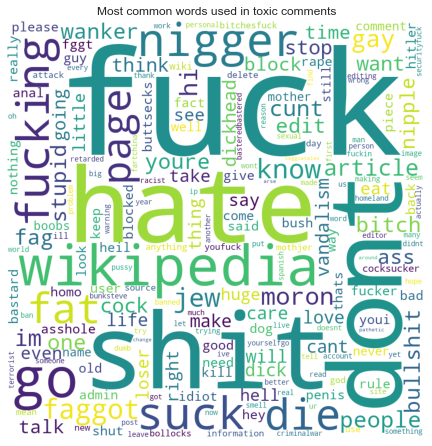

In [20]:
# displaying most frequent words used in toxic comments

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10, collocations=False).generate(' '.join(pos_words))

# plot the WordCloud image                       
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Most common words used in toxic comments')
plt.tight_layout(pad = 0)
  
plt.show()

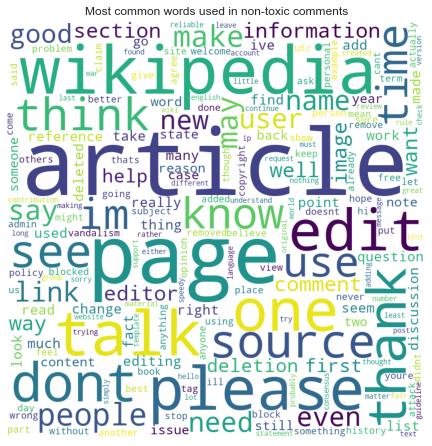

In [21]:
# displaying most frequently used words in non-toxic comments

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10, collocations=False).generate(' '.join(neg_words))

# plot the WordCloud image                       
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Most common words used in non-toxic comments')
plt.tight_layout(pad = 0)
  
plt.show()

* As expected, the words used in the two classes vary vastly

#### Frequency of most common words

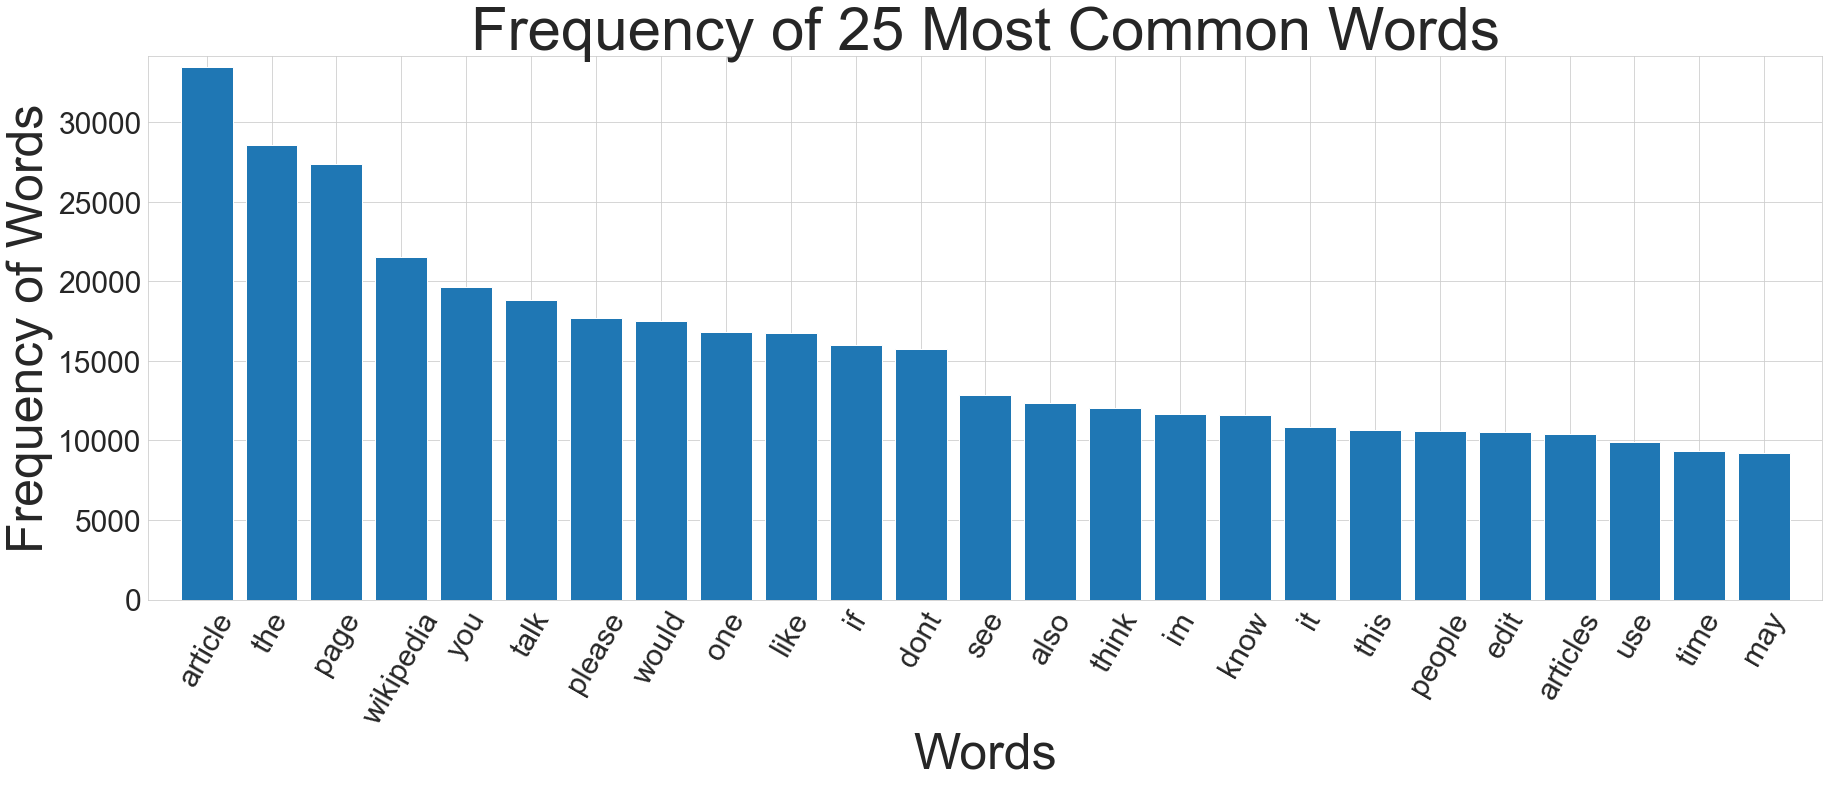

In [22]:
mostcommon_small = FreqDist(all_words).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(30,10))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=30)
plt.xticks(rotation=60, fontsize=30)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

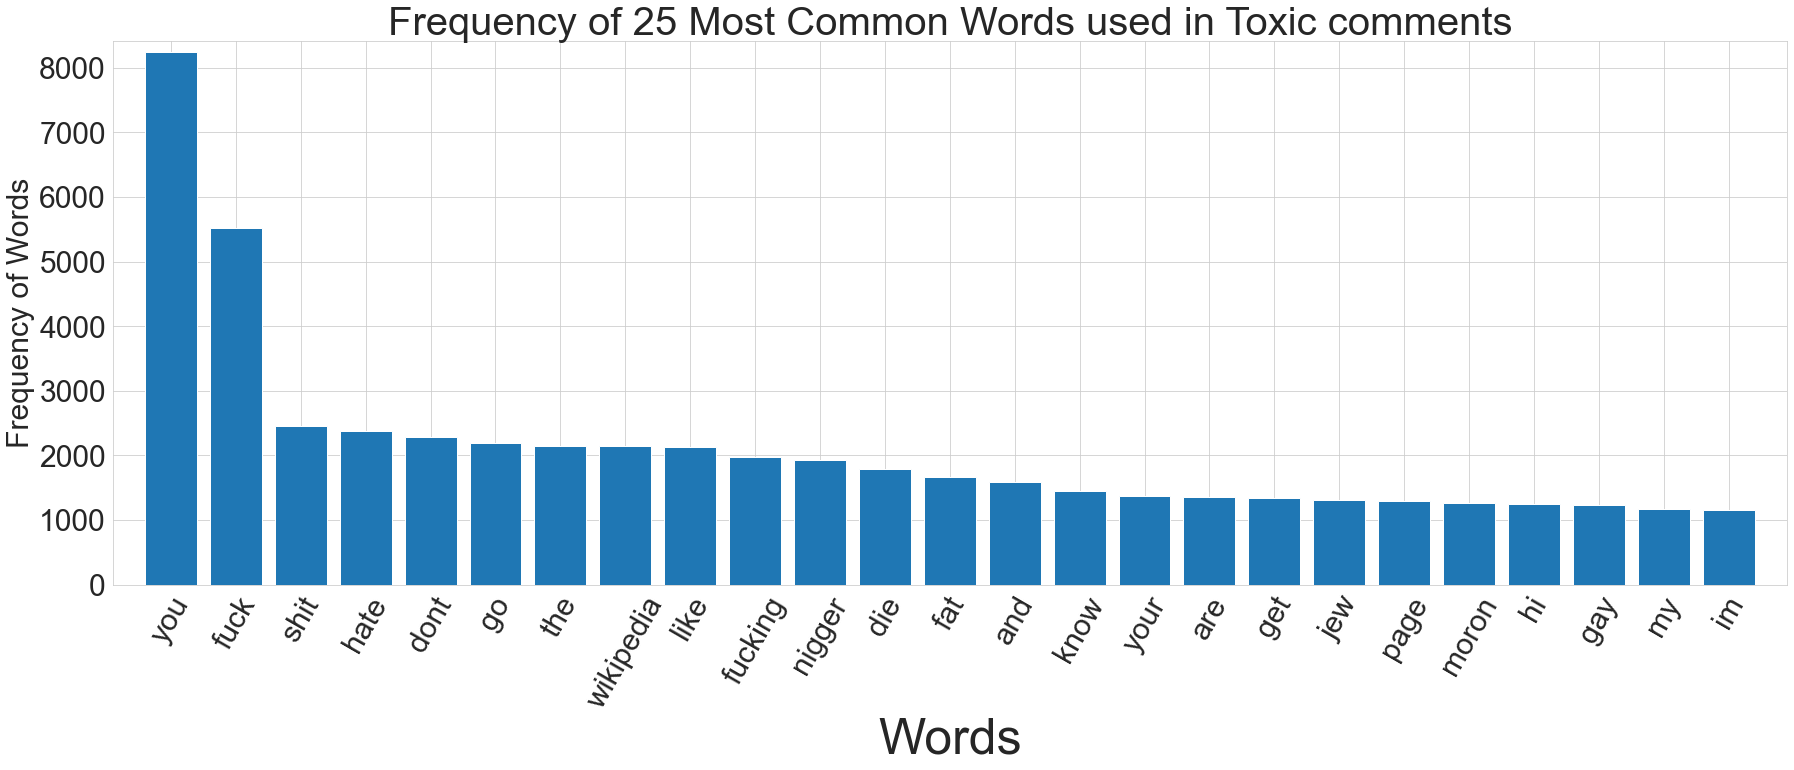

In [23]:
mostcommon_small = FreqDist(pos_words).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(30,10))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(rotation=60, fontsize=30)
plt.title('Frequency of 25 Most Common Words used in Toxic comments', fontsize=40)
plt.show()

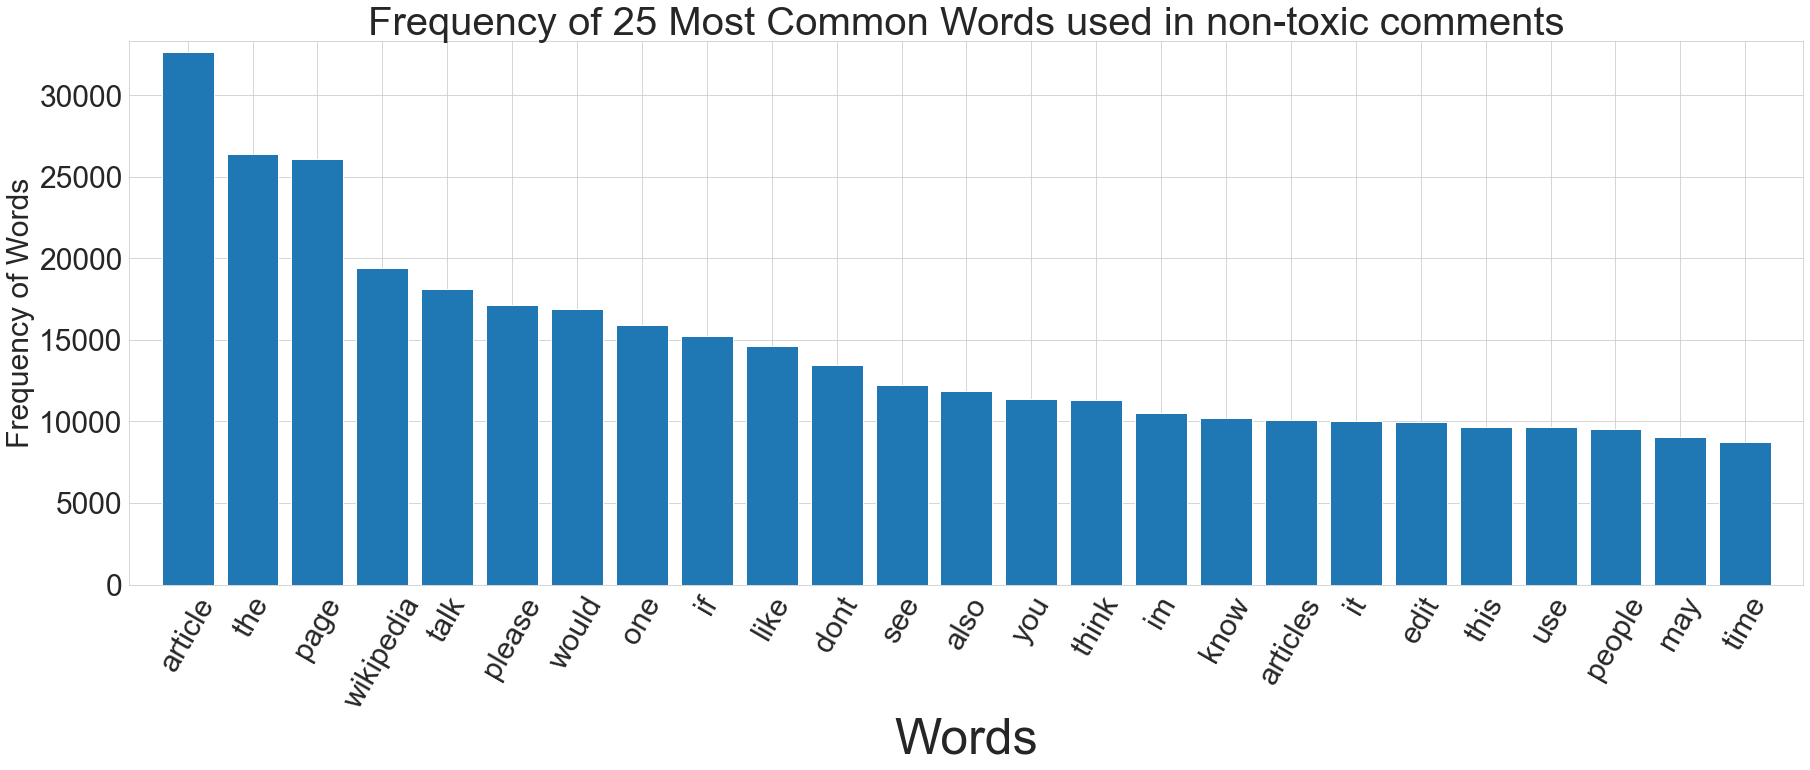

In [24]:
mostcommon_small = FreqDist(neg_words).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(30,10))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(rotation=60, fontsize=30)
plt.title('Frequency of 25 Most Common Words used in non-toxic comments', fontsize=40)
plt.show()

## Vectorizing the text

* We will be using Tf-Idf weighted Word2Vec to represent each of our words and sum up the individual word-representations element-wise to get 300-dimensional dense representation for each of our sentences.

In [83]:
# get the sentences and tokenize them

sentences_train = [word_tokenize(sentence) for sentence in train.comment_text.tolist()]
sentences_val = [word_tokenize(sentence) for sentence in val.comment_text.tolist()]
sentences_test = [word_tokenize(sentence) for sentence in test.comment_text.tolist()]

w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) # load the pretrained w2v model

In [84]:
global_wordscores, counter_model = 0, 0

def get_w2v_embeddings(model, sentence, word_scores, return_fixed_sentence=False):
    embedding = list()
    fixed_words = list()
    vappend = lambda x: fixed_words.append(x) if return_fixed_sentence else None # append new words if return_fixed_sentence is True
    
    for word in sentence:
        try:
            embedding.append(word_scores[word] * model[word])
            vappend(word)
        except KeyError:
            try:
                for split_word in wordninja.split(word):
                    embedding.append(word_scores[word] * model[split_word])
                    vappend(split_word)
            except KeyError:
                vappend('KEYERROR_DEFAULT_SKIPPED') # indicates that the particular word was not a part of the vocab and was skipped
                if not word_scores.get(word):
                    global global_wordscores
                    global_wordscores += 1
                else:
                    global counter_model
                    counter_model += 1
                
    if return_fixed_sentence:
        return embedding, fixed_words
    
    return embedding


def get_averaged_embeddings(words_list):
    if len(words_list) == 0:
        return np.array([np.inf] * 300)
    return np.mean(words_list, axis=0)

tfidf = TfidfVectorizer()
tfidf.fit_transform([' '.join(sentence) for sentence in sentences_train])
word_scores = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

# get the w2v embeddings

embedded_sentences_train = [get_w2v_embeddings(w2v_model, sentence, word_scores) for sentence in tqdm(sentences_train)]
embedded_sentences_train = [get_averaged_embeddings(words_list) for words_list in embedded_sentences_train]

embedded_sentences_val = [get_w2v_embeddings(w2v_model, sentence, word_scores) for sentence in tqdm(sentences_val)]
embedded_sentences_val = [get_averaged_embeddings(words_list) for words_list in embedded_sentences_val]


embedded_sentences_test = [get_w2v_embeddings(w2v_model, sentence, word_scores) for sentence in tqdm(sentences_test)]
embedded_sentences_test = [get_averaged_embeddings(words_list) for words_list in embedded_sentences_test]

#### Combining the embeddings with actual data-points

In [85]:
train_combined = pd.DataFrame(
    embedded_sentences_train,
    columns = [
        'dimension_' + str(i) for i in range(300)
    ]
)

val_combined = pd.DataFrame(
    embedded_sentences_val,
    columns = [
        'dimension_' + str(i) for i in range(300)
    ]
)

test_combined = pd.DataFrame(
    embedded_sentences_test,
    columns = [
        'dimension_' + str(i) for i in range(300)
    ]
)

train_combined.head()

,dimension_0,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,...,dimension_290,dimension_291,dimension_292,dimension_293,dimension_294,dimension_295,dimension_296,dimension_297,dimension_298,dimension_299
0,-0.458111,0.119045,-0.118346,0.384411,-0.074552,0.154887,0.069209,-0.472832,0.806395,0.071259,...,0.254745,0.136699,-0.556792,-0.416294,0.523955,-0.544902,-0.664670,-0.273544,-0.302260,-0.094098
1,1.184726,0.980024,2.124858,0.336624,0.281775,0.666159,-0.186235,-0.280037,0.237809,2.508843,...,0.038483,1.013045,-1.935427,0.524620,-0.817722,0.875742,0.148936,-0.811657,0.442080,-0.904587
2,-0.128003,0.063472,-0.017369,0.438774,-0.371297,-0.003979,0.119606,-0.345079,0.519531,0.383090,...,0.143320,0.514591,-0.215732,0.278261,0.109282,-0.361910,-0.242961,-0.459806,-0.234951,-0.078903
3,0.128890,0.345995,0.204774,0.529569,-0.228656,0.353072,0.257735,-0.820200,0.143500,0.805380,...,0.445362,-0.053244,-0.029303,0.270470,-0.230989,-0.100903,0.111932,-0.139392,-0.110339,0.738113
4,0.018308,0.363606,0.044894,0.360514,-0.457299,0.094099,0.475759,-0.579353,0.527458,0.182088,...,-0.396009,0.296991,-0.353973,-0.088394,-0.268292,-0.065003,-0.169465,-0.159444,-0.149729,0.179382


In [86]:
assert train_combined.shape[0] == train.shape[0]

train_combined = pd.concat([train_combined, train.reset_index(drop=True)], axis=1)
train_combined = train_combined[train_combined.dimension_0 != np.inf] # we set np.inf to rows which had empty lists during embedding

val_combined = pd.concat([val_combined, val.reset_index(drop=True)], axis=1)
val_combined = val_combined[val_combined.dimension_0 != np.inf]

test_combined = pd.concat([test_combined, test.reset_index(drop=True)], axis=1)
test_combined = test_combined[test_combined.dimension_0 != np.inf]

train_combined.head()

,dimension_0,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,...,dimension_292,dimension_293,dimension_294,dimension_295,dimension_296,dimension_297,dimension_298,dimension_299,comment_text,toxic
0,-0.458111,0.119045,-0.118346,0.384411,-0.074552,0.154887,0.069209,-0.472832,0.806395,0.071259,...,-0.556792,-0.416294,0.523955,-0.544902,-0.664670,-0.273544,-0.302260,-0.094098,so polls close ontario pm pm bc hour coverage ...,0
1,1.184726,0.980024,2.124858,0.336624,0.281775,0.666159,-0.186235,-0.280037,0.237809,2.508843,...,-1.935427,0.524620,-0.817722,0.875742,0.148936,-0.811657,0.442080,-0.904587,blowing earth,0
2,-0.128003,0.063472,-0.017369,0.438774,-0.371297,-0.003979,0.119606,-0.345079,0.519531,0.383090,...,-0.215732,0.278261,0.109282,-0.361910,-0.242961,-0.459806,-0.234951,-0.078903,french language this national library we under...,0
3,0.128890,0.345995,0.204774,0.529569,-0.228656,0.353072,0.257735,-0.820200,0.143500,0.805380,...,-0.029303,0.270470,-0.230989,-0.100903,0.111932,-0.139392,-0.110339,0.738113,wiley protocol know anything bioidentical horm...,0
4,0.018308,0.363606,0.044894,0.360514,-0.457299,0.094099,0.475759,-0.579353,0.527458,0.182088,...,-0.353973,-0.088394,-0.268292,-0.065003,-0.169465,-0.159444,-0.149729,0.179382,no facts pretty clear you changed away dsm iv ...,0


In [87]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(train_combined.drop(['comment_text', 'toxic'], axis=1))
embedding.shape

(94652, 2)

In [ ]:
# balancing our df

train_pos = pd.concat([train_combined[train_combined.toxic == 1]] * 10)
train_neg = train_combined[train_combined.toxic == 0]

train_balanced = pd.concat([train_pos, train_neg]).sample(frac = 1)

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = [sns.color_palette()[x] for x in train_balanced.toxic.map({0:0, 1:1})],
    #cmap = 'Spectral',
    s = 5,
    alpha = 0.6
)
plt.legend(['Blue-Not Toxic\nOrange-Toxic'])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Word2Vec Representation', fontsize=16)

In [ ]:
def get_c(n_components, data):
    fit = umap.UMAP(n_components=n_components)
    return fit.fit_transform(data);

In [ ]:
import plotly.express as px
df = pd.DataFrame(get_c(3, train_balanced))
df['toxic'] = train_combined['toxic']
fig = px.scatter_3d(df, x=0, y=1, z=2, color='toxic')
fig.show()

#### Adding more indicators

In [89]:
# Since we saw that average word-length and the length of a comment might be good indicators of a comment's toxicity,
# let's add them as a feature before modelling

train_combined['avg_word_length'] = train_combined.comment_text.apply(get_word_length)
train_combined['comment_length'] = train_combined.comment_text.apply(len)

val_combined['avg_word_length'] = val_combined.comment_text.apply(get_word_length)
val_combined['comment_length'] = val_combined.comment_text.apply(len)

test_combined['avg_word_length'] = test_combined.comment_text.apply(get_word_length)
test_combined['comment_length'] = test_combined.comment_text.apply(len)

train_combined.head()

,dimension_0,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,...,dimension_294,dimension_295,dimension_296,dimension_297,dimension_298,dimension_299,comment_text,toxic,avg_word_length,comment_length
0,-0.458111,0.119045,-0.118346,0.384411,-0.074552,0.154887,0.069209,-0.472832,0.806395,0.071259,...,0.523955,-0.544902,-0.664670,-0.273544,-0.302260,-0.094098,so polls close ontario pm pm bc hour coverage ...,0,5.000000,95
1,1.184726,0.980024,2.124858,0.336624,0.281775,0.666159,-0.186235,-0.280037,0.237809,2.508843,...,-0.817722,0.875742,0.148936,-0.811657,0.442080,-0.904587,blowing earth,0,6.000000,13
2,-0.128003,0.063472,-0.017369,0.438774,-0.371297,-0.003979,0.119606,-0.345079,0.519531,0.383090,...,0.109282,-0.361910,-0.242961,-0.459806,-0.234951,-0.078903,french language this national library we under...,0,5.840000,341
3,0.128890,0.345995,0.204774,0.529569,-0.228656,0.353072,0.257735,-0.820200,0.143500,0.805380,...,-0.230989,-0.100903,0.111932,-0.139392,-0.110339,0.738113,wiley protocol know anything bioidentical horm...,0,6.450000,148
4,0.018308,0.363606,0.044894,0.360514,-0.457299,0.094099,0.475759,-0.579353,0.527458,0.182088,...,-0.268292,-0.065003,-0.169465,-0.159444,-0.149729,0.179382,no facts pretty clear you changed away dsm iv ...,0,5.745455,1112


In [164]:
ct.transformers_[0][1].transform([[2, 3]])

array([[-0.37555868, -0.64144326]])

In [165]:
scaler = ct.transformers_[0][1]

In [167]:
scaler.transform([[4, 9]])

array([[-0.194978  , -0.62660016]])

In [90]:
# pre-processing the new indicators as we will be using distance based models too

col_names = ['avg_word_length', 'comment_length']

features_train = train_combined[col_names]
features_val = val_combined[col_names]
features_test = test_combined[col_names]

ct = ColumnTransformer([
        ('scaler', StandardScaler(), col_names)
    ], remainder='passthrough')

features_transformed_train = ct.fit_transform(features_train)
features_transformed_val = ct.transform(features_val) # not re-fitting to avoid data leakage
features_transformed_test = ct.transform(features_test)

train_combined.avg_word_length, train_combined.comment_length = features_transformed_train[:, 0], features_transformed_train[:, 1]
val_combined.avg_word_length, val_combined.comment_length = features_transformed_val[:, 0], features_transformed_val[:, 1]
test_combined.avg_word_length, test_combined.comment_length = features_transformed_test[:, 0], features_transformed_test[:, 1]

train_combined.head()

,dimension_0,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,...,dimension_294,dimension_295,dimension_296,dimension_297,dimension_298,dimension_299,comment_text,toxic,avg_word_length,comment_length
0,-0.458111,0.119045,-0.118346,0.384411,-0.074552,0.154887,0.069209,-0.472832,0.806395,0.071259,...,0.523955,-0.544902,-0.664670,-0.273544,-0.302260,-0.094098,so polls close ontario pm pm bc hour coverage ...,0,-0.104688,-0.413849
1,1.184726,0.980024,2.124858,0.336624,0.281775,0.666159,-0.186235,-0.280037,0.237809,2.508843,...,-0.817722,0.875742,0.148936,-0.811657,0.442080,-0.904587,blowing earth,0,-0.014397,-0.616705
2,-0.128003,0.063472,-0.017369,0.438774,-0.371297,-0.003979,0.119606,-0.345079,0.519531,0.383090,...,0.109282,-0.361910,-0.242961,-0.459806,-0.234951,-0.078903,french language this national library we under...,0,-0.028844,0.194718
3,0.128890,0.345995,0.204774,0.529569,-0.228656,0.353072,0.257735,-0.820200,0.143500,0.805380,...,-0.230989,-0.100903,0.111932,-0.139392,-0.110339,0.738113,wiley protocol know anything bioidentical horm...,0,0.026233,-0.282735
4,0.018308,0.363606,0.044894,0.360514,-0.457299,0.094099,0.475759,-0.579353,0.527458,0.182088,...,-0.268292,-0.065003,-0.169465,-0.159444,-0.149729,0.179382,no facts pretty clear you changed away dsm iv ...,0,-0.037380,2.102055


## 3.0 Modelling

#### Getting indicators and ground truth

In [91]:
X_train = train_combined.drop(['toxic', 'comment_text'], axis=1)
y_train = np.array(train_combined.toxic)

X_val = val_combined.drop(['toxic', 'comment_text'], axis=1)
y_val = np.array(val_combined.toxic)

X_test = test_combined.drop(['toxic', 'comment_text'], axis=1)
y_test = np.array(test_combined.toxic)

## 3.1 Classical ML

## Random-model

* Let's build a random-model so we can get the worst-case performance metrics as a base

In [23]:
class RandomModel(object):
    '''
    Random base-model
    '''
    def __init__(self, use='random'):
        # if use is random, we use equal probability for both classes
        # if not, we use class priors
        self.use = use
        
    def fit(self, X, y):
        if self.use == 'random':
            self.decision_boundary = 0.5
            return
        
        n_pos = sum(y) # get number of positive class data-points
        prob_pos = n_pos / len(y) # get probability of positive class
        prob_neg = (len(y) - sum(y)) / len(y) # get probability of negative class
        self.decision_boundary = max(prob_pos, prob_neg) # choose max of both as a 1D decision boundary
    
    def predict(self, X, proba=False):
        preds = []
        for i in range(X.shape[0]):
            # for each data-point
            
            rand = np.random.uniform() # get a random real-number representing the probability

            if rand >= self.decision_boundary:
                if proba:
                    # if we want to return probability, return a random-real number between
                    # the decision_boundary and 1, since rand is already greater than decision_boundary
                    preds.append(np.random.uniform(self.decision_boundary, 1))
                else:
                    preds.append(1)
            else: 
                if proba:
                    # since rand is lesser than decision_boundary, return random real-number between 0 and decision_boundary
                    # representing the probability
                    preds.append(np.random.uniform(0, self.decision_boundary))
                else:
                    preds.append(0)
        return preds
        
    
random_model_prior = RandomModel(use='prior')
random_model_prior.fit(X_train, y_train)

random_model_uniform = RandomModel(use='random')
random_model_uniform.fit(X_train, y_train)

random_prior_preds = random_model_prior.predict(X_val, proba=True)
random_uniform_preds = random_model_uniform.predict(X_val)

In [24]:
random_table = PrettyTable()
random_table.field_names = ['Probability', 'Accuracy', 'Log-loss', 'Precision', 'Recall', 'F1']

random_table.add_row([
    'Class Priors',
    accuracy_score(y_pred = random_model_prior.predict(X_val), y_true = y_val),
    log_loss(y_pred = random_model_prior.predict(X_val), y_true = y_val),
    precision_score(y_pred = random_model_prior.predict(X_val), y_true = y_val),
    recall_score(y_pred = random_model_prior.predict(X_val), y_true = y_val),
    f1_score(y_pred = random_model_prior.predict(X_val), y_true = y_val)
])

random_table.add_row([
    'Random Uniform',
    accuracy_score(y_pred = random_model_uniform.predict(X_val), y_true = y_val),
    log_loss(y_pred = random_model_uniform.predict(X_val, proba=True), y_true = y_val),
    precision_score(y_pred = random_model_uniform.predict(X_val), y_true = y_val),
    recall_score(y_pred = random_model_uniform.predict(X_val), y_true = y_val),
    f1_score(y_pred = random_model_uniform.predict(X_val), y_true = y_val)
])

random_table.title = 'Random Model'
print(random_table)

+-----------------------------------------------------------------------------------------------------------------------------+
|                                                         Random Model                                                        |
+----------------+---------------------+--------------------+---------------------+---------------------+---------------------+
|  Probability   |       Accuracy      |      Log-loss      |      Precision      |        Recall       |          F1         |
+----------------+---------------------+--------------------+---------------------+---------------------+---------------------+
|  Class Priors  |  0.8297665369649806 | 5.706307366002021  | 0.10915371329879102 | 0.08279430789133248 | 0.09225029676106494 |
| Random Uniform | 0.49899585791389484 | 1.0017175638317923 | 0.09695221372130942 |  0.5064683053040103 | 0.16124469589816126 |
+----------------+---------------------+--------------------+---------------------+---------------------

* We build two different Random Models. This is because we want to see how the data-imbalance affects our predictive power as well. In any case, we should not be seeing an F1 that's worse than 0.16 and an Accuracy that's lower than 83%

### Distance based models

### Logistic Regression

In [16]:
# We saw in the UMAP projection above that our data was fairly separable even in 2-dimensions. 
# It can be safe to assume that in higher-dimensions, such as in 302 dimensions, there can be a hyper-plane
# that separates our positive and negative class data-points much better.
# Hence, we will try to fit a simple Logistic Regression to find if such a hyper-plane exists

# For hyper-parameter tuning, we will use GridSearch optimization since it's just one-parameter

param_search = GridSearchCV(
    estimator = LogisticRegression(
        random_state = 42, 
        n_jobs = 4,
    ),
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]},
    scoring = 'f1',
    n_jobs = 4,
    verbose = 3
)

param_search.fit(X_train_balanced, y_train_balanced)
print('Best parameter: {}'.format(param_search.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.2min finished


Best parameter: {'C': 0.1}


In [17]:
# fitting the model with the tuned hyper-parameter

lr = LogisticRegression(C=param_search.best_params_['C'], class_weight='balanced', random_state=42, n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1, random_state=42)

In [18]:
lr_table = PrettyTable()
lr_table.field_names = ['Accuracy', 'Log-loss', 'Precision', 'Recall', 'F1']
lr_table.add_row([
    accuracy_score(y_pred = lr.predict(X_val), y_true = y_val),
    log_loss(y_pred = lr.predict(X_val), y_true = y_val),
    precision_score(y_pred = lr.predict(X_val), y_true = y_val),
    recall_score(y_pred = lr.predict(X_val), y_true = y_val),
    f1_score(y_pred = lr.predict(X_val), y_true = y_val)
])
lr_table.title = 'Logistic Regression'
print(lr_table)

+-----------------------------------------------------------------------------------------------------+
|                                         Logistic Regression                                         |
+--------------------+------------------+-------------------+--------------------+--------------------+
|      Accuracy      |     Log-loss     |     Precision     |       Recall       |         F1         |
+--------------------+------------------+-------------------+--------------------+--------------------+
| 0.8278837705535333 | 5.94481425993285 | 0.350306518203428 | 0.9055627425614489 | 0.5051871898962562 |
+--------------------+------------------+-------------------+--------------------+--------------------+


* We notice that our log-loss is much worse than even a random-model, indicating that the model failed to graph a hyper-plane that could separate our data linearly

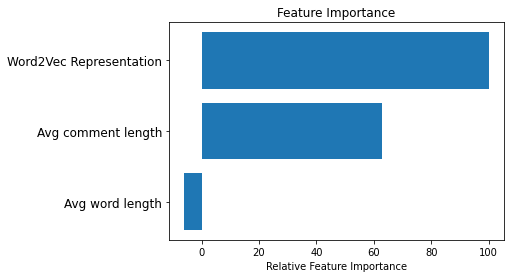

In [19]:
feature_importance = [np.mean(np.abs(lr.coef_[0][: -2]))]
feature_importance.extend(lr.coef_[0][-2:])
feature_importance = np.array(feature_importance)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(['Word2Vec Representation', 'Avg word length', 'Avg comment length'])[sorted_idx], fontsize=12)
featax.set_xlabel('Relative Feature Importance')
plt.title('Feature Importance')
_ = plt.plot()

* As expected, we notice that the contents of the message or the word2vec representation has the highest impact on model performance, but it is also interesting to see that the comment length makes almost 60% of the same impact as the comment's contents.

## Support Vector Machines

* Since we learned that Logistic Regression failed, Linear-SVM would also most-likely fail. However, let us investigate this.

In [396]:
# For hyper-parameter tuning, we will use GridSearch optimization since it's just one-parameter

param_search = GridSearchCV(
    estimator = SGDClassifier(
        loss = 'hinge',
        class_weight = 'balanced', # this is cruical as it will give more weightage to our positive class datapoints
        random_state = 42
    ),
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    scoring = 'f1',
    n_jobs = -1,
    verbose = 5
)

param_search.fit(X_train, y_train)
print('Best parameter: {}'.format(param_search.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    8.1s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   11.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   12.8s finished


Best parameter: {'alpha': 0.01}


In [397]:
svc = SGDClassifier(
    loss = 'hinge',
    class_weight = 'balanced',
    random_state = 42,
    alpha = param_search.best_params_['alpha'],
    n_jobs = -1,
)

svc.fit(X_train, y_train)

SGDClassifier(alpha=0.01, class_weight='balanced', n_jobs=-1, random_state=42)

In [398]:
svc_table = PrettyTable()
svc_table.field_names = ['Accuracy', 'Log-loss', 'Precision', 'Recall', 'F1']
svc_table.add_row([
    accuracy_score(y_pred = svc.predict(X_val), y_true = y_val),
    log_loss(y_pred = svc.predict(X_val), y_true = y_val),
    precision_score(y_pred = svc.predict(X_val), y_true = y_val),
    recall_score(y_pred = svc.predict(X_val), y_true = y_val),
    f1_score(y_pred = svc.predict(X_val), y_true = y_val)
])
svc_table.title = 'SVM'
print(svc_table)

+-------------------------------------------------------------------------------------------------------+
|                                                  SVM                                                  |
+--------------------+-------------------+--------------------+--------------------+--------------------+
|      Accuracy      |      Log-loss     |     Precision      |       Recall       |         F1         |
+--------------------+-------------------+--------------------+--------------------+--------------------+
| 0.8968415770159647 | 3.563037155096443 | 0.4721141374837873 | 0.8527443105756358 | 0.6077519379844961 |
+--------------------+-------------------+--------------------+--------------------+--------------------+


* As expected, we see the same degree of performance from linear-SVM as LR.
* Kernel-SVM cannot be used on the dataset as we know that it scales quadratically with the number of data-points.

## Tree-based models

## Random Forest

In [403]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [407]:
param_search = RandomizedSearchCV(
    estimator = RandomForestClassifier(
        class_weight = 'balanced',
        random_state = 42,
    ),
    param_distributions = random_grid,
    verbose = 5,
    random_state = 42,
    n_jobs = -1,
)

param_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed: 183.3min remaining: 15.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 206.5min finished


RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=5)

In [408]:
param_search.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [22]:
rf = RandomForestClassifier(
    n_estimators = param_search.best_params_['n_estimators'],
    min_samples_split = param_search.best_params_['min_samples_split'],
    min_samples_leaf = param_search.best_params_['min_samples_leaf'],
    max_features = param_search.best_params_['max_features'],
    max_depth = param_search.best_params_['max_depth'],
    bootstrap = param_search.best_params_['bootstrap'],
    random_state = 42,
    n_jobs = -1,
    verbose = 3
)

rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 600building tree 2 of 600
building tree 3 of 600

building tree 4 of 600building tree 5 of 600

building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.9s


building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600
building tree 44 of 600
building tree 45 of 600
building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 55 of 600
building tree 56 of 600
building tree 57 of 600
building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 62 of 600
building tree 63 of 600
building tree 64 of 600
building tree 65

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   51.8s


building tree 120 of 600
building tree 121 of 600
building tree 122 of 600
building tree 123 of 600
building tree 124 of 600
building tree 125 of 600
building tree 126 of 600
building tree 127 of 600
building tree 128 of 600
building tree 129 of 600
building tree 130 of 600
building tree 131 of 600
building tree 132 of 600
building tree 133 of 600
building tree 134 of 600
building tree 135 of 600
building tree 136 of 600
building tree 137 of 600
building tree 138 of 600
building tree 139 of 600
building tree 140 of 600
building tree 141 of 600
building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.1min


building tree 281 of 600
building tree 282 of 600
building tree 283 of 600
building tree 284 of 600
building tree 285 of 600
building tree 286 of 600
building tree 287 of 600
building tree 288 of 600
building tree 289 of 600
building tree 290 of 600
building tree 291 of 600
building tree 292 of 600
building tree 293 of 600
building tree 294 of 600
building tree 295 of 600
building tree 296 of 600
building tree 297 of 600
building tree 298 of 600
building tree 299 of 600
building tree 300 of 600
building tree 301 of 600
building tree 302 of 600
building tree 303 of 600
building tree 304 of 600
building tree 305 of 600
building tree 306 of 600
building tree 307 of 600
building tree 308 of 600
building tree 309 of 600
building tree 310 of 600
building tree 311 of 600
building tree 312 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 318 of 600
building tree 319 of 600
building tree 320 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.9min


building tree 506 of 600
building tree 507 of 600
building tree 508 of 600
building tree 509 of 600
building tree 510 of 600
building tree 511 of 600
building tree 512 of 600
building tree 513 of 600
building tree 514 of 600
building tree 515 of 600
building tree 516 of 600
building tree 517 of 600
building tree 518 of 600
building tree 519 of 600
building tree 520 of 600
building tree 521 of 600
building tree 522 of 600
building tree 523 of 600
building tree 524 of 600
building tree 525 of 600
building tree 526 of 600
building tree 527 of 600
building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 535 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 544 of 600
building tree 545 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.6min finished


RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=600, n_jobs=-1, random_state=42, verbose=3)

In [23]:
rf_table = PrettyTable()
rf_table.field_names = ['Accuracy', 'Log-loss', 'Precision', 'Recall', 'F1']
rf_table.add_row([
    accuracy_score(y_pred = rf.predict(X_val), y_true = y_val),
    log_loss(y_pred = rf.predict(X_val), y_true = y_val),
    precision_score(y_pred = rf.predict(X_val), y_true = y_val),
    recall_score(y_pred = rf.predict(X_val), y_true = y_val),
    f1_score(y_pred = rf.predict(X_val), y_true = y_val)
])
rf_table.title = 'Random Forest'
print(rf_table)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(

+--------------------------------------------------------------------------------------------------------+
|                                             Random Forest                                              |
+--------------------+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |      Log-loss      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0.9405673402786494 | 2.0527431123118998 | 0.7804307116104869 | 0.5391332470892626 | 0.6377199693955624 |
+--------------------+--------------------+--------------------+--------------------+--------------------+


## Gradient boosted Decision Trees

In [36]:
pos_df, neg_df = train_combined[train_combined.toxic == 1], train_combined[train_combined.toxic == 0]

In [58]:
mul = neg_df.shape[0] // pos_df.shape[0]
balanced_train  = pd.concat([pd.concat([pos_df] * mul), neg_df]).sample(frac=1).reset_index(drop=True)

In [60]:
balanced_train.toxic.value_counts()

0    84347
1    82020
Name: toxic, dtype: int64

In [61]:
X_train_balanced, y_train_balanced = balanced_train.drop(['toxic', 'comment_text'], axis=1), np.array(balanced_train.toxic)

In [25]:
# A parameter grid for XGBoost
params = {
    'n_estimators': [100, 500, 600, 800, 1000, 1500],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

param_search = RandomizedSearchCV(
    estimator = XGBClassifier(
        n_jobs = 4,
        random_state = 42
    ),
    param_distributions = params,
    verbose = 5,
    random_state = 42,
    n_jobs = 4,
    scoring = 'f1'
)

param_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 91.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 281.6min finished
C:\Users\yogid\anaconda3\envs\main\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:26:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=Non

In [71]:
# with class balance

# A parameter grid for XGBoost
params = {
    'n_estimators': [100, 500, 600, 800, 1000, 1500],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

param_search = RandomizedSearchCV(
    estimator = XGBClassifier(
        n_jobs = 4,
        random_state = 42
    ),
    param_distributions = params,
    verbose = 5,
    random_state = 42,
    n_jobs = 4,
    scoring = 'f1'
)

param_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 126.7min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 400.1min finished
C:\Users\yogid\anaconda3\envs\main\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=Non

In [72]:
param_search.best_params_ # bal

{'subsample': 1.0,
 'n_estimators': 1000,
 'min_child_weight': 10,
 'max_depth': 5,
 'gamma': 1,
 'colsample_bytree': 0.8}

In [25]:
gbdt = XGBClassifier(
    n_estimators = param_search.best_params_['n_estimators'],
    subsample = param_search.best_params_['subsample'],
    min_child_weight = param_search.best_params_['min_child_weight'],
    max_depth = param_search.best_params_['max_depth'],
    gamma = param_search.best_params_['gamma'],
    colsample_bytree = param_search.best_params_['colsample_bytree'],
    n_jobs = -1,
    verbose = 5,
    random_state = 42
)

gbdt.fit(X_train_balanced, y_train_balanced)

C:\Users\yogid\anaconda3\envs\main\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:05:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbose=5, verbosity=None)

In [65]:
gbdt_table = PrettyTable()
gbdt_table.field_names = ['Accuracy', 'Log-loss', 'Precision', 'Recall', 'F1']
gbdt_table.add_row([
    accuracy_score(y_pred = gbdt.predict(X_val), y_true = y_val),
    log_loss(y_pred = gbdt.predict(X_val), y_true = y_val),
    precision_score(y_pred = gbdt.predict(X_val), y_true = y_val),
    recall_score(y_pred = gbdt.predict(X_val), y_true = y_val),
    f1_score(y_pred = gbdt.predict(X_val), y_true = y_val)
])
gbdt_table.title = 'GBDT'
print(gbdt_table)

+--------------------------------------------------------------------------------------------------------+
|                                                  GBDT                                                  |
+--------------------+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |      Log-loss      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0.9090937617672901 | 3.1398464137913416 | 0.5208645409800985 | 0.7871927554980596 | 0.6269156471345783 |
+--------------------+--------------------+--------------------+--------------------+--------------------+


In [67]:
gbdt_new = XGBClassifier(
    n_estimators = 700,
    subsample = param_search.best_params_['subsample'],
    min_child_weight = param_search.best_params_['min_child_weight'],
    max_depth = param_search.best_params_['max_depth'],
    gamma = param_search.best_params_['gamma'],
    colsample_bytree = param_search.best_params_['colsample_bytree'],
    n_jobs = -1,
    verbose = 5,
    random_state = 42
)

gbdt_new.fit(X_train_balanced, y_train_balanced)

C:\Users\yogid\anaconda3\envs\main\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:08:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:08:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbose=5,
              verbosity=None)

In [70]:
gbdt_table = PrettyTable()
gbdt_table.field_names = ['Accuracy', 'Log-loss', 'Precision', 'Recall', 'F1']
gbdt_table.add_row([
    accuracy_score(y_pred = gbdt_new.predict(X_val), y_true = y_val),
    log_loss(y_pred = gbdt_new.predict(X_val), y_true = y_val),
    precision_score(y_pred = gbdt_new.predict(X_val), y_true = y_val),
    recall_score(y_pred = gbdt_new.predict(X_val), y_true = y_val),
    f1_score(y_pred = gbdt_new.predict(X_val), y_true = y_val)
])
gbdt_table.title = 'GBDT'
print(gbdt_table)

+--------------------------------------------------------------------------------------------------------+
|                                                  GBDT                                                  |
+--------------------+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |      Log-loss      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0.8948788753608635 | 3.6308244448675837 | 0.4755496588324488 | 0.8114489003880984 | 0.5996653919694072 |
+--------------------+--------------------+--------------------+--------------------+--------------------+


## Deep Learning models

## MLP

In [206]:
'''
import pickle

with open('data_saves.pickle', 'wb') as save_file:
    pickle.dump([X_train_balanced, y_train_balanced, X_train, y_train, X_val, y_val, X_test, y_test], save_file)
'''

In [3]:
import pickle

with open('data_saves.pickle', 'rb') as save_file:
    X_train_balanced, y_train_balanced, X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(save_file)

In [93]:
from torch.utils.data import Dataset, DataLoader
import torch

## train data
class TrainLoader(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

if not isinstance(X_train_balanced, np.ndarray):
    X_train_balanced = X_train_balanced.to_numpy()
    
train_data = TrainLoader(
    torch.FloatTensor(X_train_balanced), 
    torch.FloatTensor(y_train_balanced)
)


## test data    
class TestLoader(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
  

if not isinstance(X_test, np.ndarray):
    X_test = X_test.to_numpy()

test_data = TestLoader(
    torch.FloatTensor(X_test)
)

if not isinstance(X_val, np.ndarray):
    X_val = X_val.to_numpy()

val_data = TestLoader(
    torch.FloatTensor(X_val)
)

train_data_check = TestLoader(
    torch.FloatTensor(X_train_balanced)
)

In [94]:
BATCH_SIZE = 512
LEARNING_RATE = 0.001
EPOCHS = 50
device = 'cuda:0'

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)
val_loader = DataLoader(dataset = val_data, batch_size = 1)
train_check_loader = DataLoader(dataset=train_data_check, batch_size=1)

In [108]:
# let's try a simple three-layer dense architecture

# first dense layer: 304 -> 128
# second: 128 -> 64 
# third: 64 -> 2 (softmax)

class MLP(nn.Module):
    def __init__(self, batch_size = 256):
        super().__init__() # initializing super class
        
        self.batch_size = batch_size
        
        # first dense layer
        self.dense_1 = nn.Linear(
            in_features = 302,
            out_features = 1024
        )
        
        self.dense_2 = nn.Linear(
            in_features = 1024,
            out_features = 512
        )
        
        self.dense_3 = nn.Linear(
            in_features = 512,
            out_features = 256
        )
        
        self.dense_4 = nn.Linear(
            in_features = 256,
            out_features = 128
        )
        
        self.dense_5 = nn.Linear(
            in_features = 128,
            out_features = 64
        )
        
        self.dense_6 = nn.Linear(
            in_features = 64,
            out_features = 32
        )
        
        self.out = nn.Linear(
            in_features = 32,
            out_features = 1
        )
        
        self.dropout_p4 = nn.Dropout(p=0.4)
        self.dropout_p5 = nn.Dropout(p=0.5)
        self.dropout_p3 = nn.Dropout(p=0.3)
        
        self.batchnorm_1024 = nn.BatchNorm1d(1024)
        self.batchnorm_512 = nn.BatchNorm1d(512)
        self.batchnorm_256 = nn.BatchNorm1d(256)
        self.batchnorm_128 = nn.BatchNorm1d(128)
        self.batchnorm_64 = nn.BatchNorm1d(64)
        self.batchnorm_32 = nn.BatchNorm1d(32)
        
        return
    
        
    def forward(self, X: np.array):
        
        X = torch.relu(self.dense_1(X))
        X = self.dropout_p5(X)
        X = self.batchnorm_1024(X)
        
        X = torch.relu(self.dense_2(X))
        X = self.dropout_p4(X) # 3 -> 5 -> 4
        X = self.batchnorm_512(X)

        X = torch.relu(self.dense_3(X))
        X = self.dropout_p5(X)
        X = self.batchnorm_256(X)
        
        X = torch.relu(self.dense_4(X))
        X = self.dropout_p3(X)
        X = self.batchnorm_128(X)
        
        X = torch.relu(self.dense_5(X))
        X = self.dropout_p3(X)
        X = self.batchnorm_64(X)

        
        X = torch.relu(self.dense_6(X))
        X = self.batchnorm_32(X)
        
        X = self.out(X)
        
        return X

In [109]:
model = MLP(batch_size = BATCH_SIZE)
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MLP(
  (dense_1): Linear(in_features=302, out_features=1024, bias=True)
  (dense_2): Linear(in_features=1024, out_features=512, bias=True)
  (dense_3): Linear(in_features=512, out_features=256, bias=True)
  (dense_4): Linear(in_features=256, out_features=128, bias=True)
  (dense_5): Linear(in_features=128, out_features=64, bias=True)
  (dense_6): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (dropout_p4): Dropout(p=0.4, inplace=False)
  (dropout_p5): Dropout(p=0.5, inplace=False)
  (dropout_p3): Dropout(p=0.3, inplace=False)
  (batchnorm_1024): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_512): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_256): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_128): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [110]:
from pdb import set_trace

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [106]:
def get_preds(
        data_loader,
        draw_table=True,
        ground_truths=None,
        header='MLP'
    ):
    
    preds = []
    print(model)
    model.eval()
    
    with torch.no_grad():
        for X_batch in tqdm(data_loader):
            
            X_batch = X_batch.to(device)
            y_pred = model(X_batch) # we get sigmoided output
            y_pred = torch.sigmoid(y_pred)
            
            y_pred_tag = torch.round(y_pred)
            preds.append(y_pred_tag.cpu().numpy())
    
    preds = [a.squeeze().tolist() for a in preds]

    if not draw_table:
        return preds
    
    if ground_truths is None:
        raise ValueError('Ground truths not found')
    
    
    table = PrettyTable()
    table.field_names = ['Accuracy', 'Log-loss', 'Precision', 'Recall', 'F1']
    table.add_row([
        accuracy_score(y_pred = preds, y_true = ground_truths),
        log_loss(y_pred = preds, y_true = ground_truths),
        precision_score(y_pred = preds, y_true = ground_truths),
        recall_score(y_pred = preds, y_true = ground_truths),
        f1_score(y_pred = preds, y_true = ground_truths)
    ])
    table.title = header
    print(table)
    
    return preds

In [112]:
val_preds = get_preds(
    data_loader = val_loader,
    draw_table = True,
    ground_truths = y_val,
    header = 'Validation'
)

MLP(
  (dense_1): Linear(in_features=302, out_features=1024, bias=True)
  (dense_2): Linear(in_features=1024, out_features=512, bias=True)
  (dense_3): Linear(in_features=512, out_features=256, bias=True)
  (dense_4): Linear(in_features=256, out_features=128, bias=True)
  (dense_5): Linear(in_features=128, out_features=64, bias=True)
  (dense_6): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (dropout_p4): Dropout(p=0.4, inplace=False)
  (dropout_p5): Dropout(p=0.5, inplace=False)
  (dropout_p3): Dropout(p=0.3, inplace=False)
  (batchnorm_1024): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_512): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_256): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_128): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 


+--------------------------------------------------------------------------------------------------------+
|                                               Validation                                               |
+--------------------+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |      Log-loss      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0.9455635040160643 | 1.8801857427194293 | 0.7594646271510517 | 0.6423027166882277 | 0.6959873839144911 |
+--------------------+--------------------+--------------------+--------------------+--------------------+


In [113]:
test_preds = get_preds(
    data_loader = test_loader,
    draw_table = True,
    ground_truths = y_test,
    header = 'Test'
)

MLP(
  (dense_1): Linear(in_features=302, out_features=1024, bias=True)
  (dense_2): Linear(in_features=1024, out_features=512, bias=True)
  (dense_3): Linear(in_features=512, out_features=256, bias=True)
  (dense_4): Linear(in_features=256, out_features=128, bias=True)
  (dense_5): Linear(in_features=128, out_features=64, bias=True)
  (dense_6): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (dropout_p4): Dropout(p=0.4, inplace=False)
  (dropout_p5): Dropout(p=0.5, inplace=False)
  (dropout_p3): Dropout(p=0.3, inplace=False)
  (batchnorm_1024): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_512): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_256): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_128): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 


+------------------------------------------------------------------------------------------------------+
|                                                 Test                                                 |
+--------------------+-------------------+--------------------+--------------------+-------------------+
|      Accuracy      |      Log-loss     |     Precision      |       Recall       |         F1        |
+--------------------+-------------------+--------------------+--------------------+-------------------+
| 0.9472479222204798 | 1.822007215163966 | 0.7670432411375147 | 0.6449394038650508 | 0.700711743772242 |
+--------------------+-------------------+--------------------+--------------------+-------------------+


In [213]:
'''with open('24_4_saves/dependencies_24_4.pickle', 'wb') as save_file:
    pickle.dump([
        word_scores,
        scaler
    ], save_file)'''

In [214]:
#torch.save(model, '24_4_saves/mlp_model.pth')

In [216]:
torch.save(model.state_dict(), '24_4_saves/mlp_model_state_dict.pth')

In [205]:
class Preprocesser():
    def __init__(
        self,
        word_scores: dict, # stores the TF-IDF value of all the words stored in the training dataset,
        scaler: StandardScaler() # to scale our newly engineered features
        dimension: int = 300,
        dependencies_path: str = None
    ):
        self.dimension = dimension
        
        if word_scores and scaler:
            self.word_scores = word_scores
            self.scaler = scaler
            
        elif depencies_path:
            with open(dependencies_path)
        
        self.w2v_model = w2v_model
        #self.w2v_model = KeyedVectors.load_word2vec_format(
            #'GoogleNews-vectors-negative300.bin', binary=True
        #) # load the pretrained w2v model
        
        
    def preprocess_text(self, text):

        def remove_special_chars_and_numbers(text):
            '''
            Returns text without any special characters and numbers
            '''
            return text.translate(str.maketrans('', '', string.punctuation)).translate(str.maketrans('', '', string.digits))

        def remove_stopwords(text):
            '''
            Removes stopwords from text
            '''
            new_text = list()
            for word in text.split():
                if word not in stop_words:
                    new_text.append(word)
            return ' '.join(new_text)

        def remove_html_tags(text):
            '''
            Removes html tags from the text
            '''
            return BeautifulSoup(str(text), 'html.parser').get_text()

        def remove_non_english_words(text):
            '''
            Removes all non-english words in the text
            '''
            pattern = r'[^\x00-\x7f]'
            new_text = ''
            for element_index, element in enumerate(text):
                if not re.search(pattern, element):
                    new_text = new_text + element
            return new_text

        def do_lemmatization(text):
            lemma = WordNetLemmatizer()
            return lemma.lemmatize(text)

        def convert_lower_case(text):
            return text.lower()

        def remove_single_alphabets(text):
            new_text = list()
            for word in text.split():
                if len(word) == 1:
                    if word.isalpha():
                        continue
                new_text.append(word)
            return ' '.join(new_text)

        text = remove_html_tags(text)
        text = remove_special_chars_and_numbers(text)
        text = remove_stopwords(text)
        text = remove_non_english_words(text)
        text = convert_lower_case(text)
        text = do_lemmatization(text)
        text = remove_single_alphabets(text)
        
        return text
        
    
    
    def get_avg_word_length(
        self,
        text: str
    ) -> float:
        
        return sum([len(word) for word in text.split()]) / len(text.split())
    
    def get_message_length(
        self,
        text: str
    ) -> int:
        
        return len(text)
    
    
    def get_w2v_embeddings(
        self,
        message: str
    ) -> np.ndarray:
        
        embedding = list()
        fixed_words = list()
        
        message = word_tokenize(message)
        
        for word in message:
            try:
                embedding.append(self.word_scores[word] * self.w2v_model[word])
            except KeyError:
                try:
                    for split_word in wordninja.split(word):
                        embedding.append(self.word_scores[word] * self.w2v_model[split_word])
                except KeyError:
                    pass # the particular word was not a part of the vocab and was skipped

        return np.array(embedding)
    
    def get_averaged_embeddings(
        self,
        embedded_message: np.ndarray
    ) ->  np.ndarray:
        
        if len(embedded_message) == 0:
            return np.array([np.inf] * 300)
        
        return np.mean(embedded_message, axis=0)
    
    
    def preprocess(
        self,
        message: str
    ) -> np.ndarray:
        
        message = self.preprocess_text(message)
        avg_word_len = self.get_avg_word_length(message)
        message_len = self.get_message_length(message)
        
        embedded_message = self.get_averaged_embeddings(
            self.get_w2v_embeddings(message)
        )
        
        embedded_message = np.append(
            embedded_message,
            self.scaler.transform([
                [
                    avg_word_len,
                    message_len
                ]
            ])
        )
        
        return embedded_message
    
    
class HateSpeechClassifier():
    def __init__(
        self,
        clf: MLP,
        pp: Preprocesser
        
    ) -> None:
        
        self.clf = clf
        self.pp = pp
        
    def get_model_output(
        self,
        message: str
    ) -> torch.Tensor:
        
        message = self.pp.preprocess(message)
        return torch.round(
            torch.sigmoid(
                self.clf(
                    torch.Tensor([
                        message
                    ]).cuda()
                )
            )
        ).squeeze(1).detach().cpu().numpy()
        
        
    def predict(
        self,
        message: str
    ) -> bool:
        
        return bool(self.get_model_output(message))

In [206]:
pp = Preprocesser(
    word_scores = word_scores,
    dimension = 300
)

In [210]:
clf = HateSpeechClassifier(clf = model, pp = pp)
clf.predict('love you')

False